# Linear Programming: Multi Commodity Production Planning

By: Mansur M. Arief

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/analytics-project-simt-its/analytics-project-simt-its.github.io/blob/main/notebooks/pyomo_multi-commodity_production_planning.ipynb)

In [1]:
%pip install pyomo
%pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 3.4 MB/s eta 0:00:00m eta 0:00:010:00:01m
  Preparing metadata (setup.py) ... done
  Using cached ply-3.11-py2.py3-none-any.whl (49 kB)
  Created wheel for pyomo: filename=Pyomo-6.7.2-py2.py3-none-any.whl size=3551127 sha256=c8ca3a95607ba9c9b846bc600c2aaedd38e42e4a2eaa50a711f13be892efd43d
  Stored in directory: /Users/mansur/Library/Caches/pip/wheels/4e/1a/f3/27ca27745bf55ac4c7b25eab470f6188bed313c4e987ec767f
Successfully built pyomo
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd


# Model

Objective: find the product grades to maximize profits


Set:
- $I$: set of grade types
- $J$: set of raw materials
- $K$: set of processing methods
- $T$: set of time periods


Parameter:
- $p_i$: price of grade $i$
- $d_{it}$: demand of grade $i$ at time $t$
- $m_{ik}$: 1 if grade $i$ can be produced by processing method $k$, 0 otherwise
- $n_{ijk}$: quantity of raw material $j$ needed to produce 1 ton of grade $i$ by processing method $k$
- $c_j$: cost of raw material $j$
- $h_j$: holding cost of raw material $j$
- $s_i$: holding cost for grade $i$
- $r_j$: reorder cost for raw material $j$
- $b$: bagging cost/ton (in USD)
- $t_{ik}$: time to produce 1 ton of grade $i$ by processing method $k$
- $e_{ik}$: energy consumption to produce 1 ton of grade $i$ by processing method $k$
- $u^{min}, u^{max}$: min and max material to order 
- $M_{ik}$ : production capacity of processing method $k$ for grade $i$
- BigM : 99999
- $Cap_k$: capacity of processing method $k$

Variable:
- $x_{ikt}$: quantity of grade $i$ produced by processing method $k$ at time $t$
- $y_{it}$: quantity of grade $i$ in stock at time $t$
- $z_{it}$: quantity of grade $i$ sold at time $t$
- $w_{jt}$: indicator variable if raw material $j$ ordered at time $t$
- $u_{jt}$: quantity of raw material $j$ ordered at time $t$
- $v_{jt}$: quantity of raw material $j$ in stock at time $t$




Objective function:

maximize profit = revenue - (cost of energy/utility + cost of manpower + cost of bagging + cost of holding products inventory + cost of raw materials + cost of holding raw materials inventory + cost of reordering materials)


- Revenue: $\sum_{i \in I} \sum_{t \in T} p_i z_{it}$
- Cost of energy/utility: $\sum_{i \in I} \sum_{k \in K} \sum_{t \in T} e_{ik} x_{ikt}$
- Cost of manpower: $\sum_{i \in I} \sum_{k \in K} \sum_{t \in T} t_{ik} x_{ikt}$
- Cost of bagging: $\sum_{i \in I} \sum_{k \in K} \sum_{t \in T} b x_{ikt}$
- Cost of holding products inventory: $\sum_{i \in I} \sum_{t \in T} s_i y_{it}$
- Cost of raw materials: $\sum_{j \in J} \sum_{t \in T} c_j u_{jt}$
- Cost of holding raw materials inventory: $\sum_{j \in J} \sum_{t \in T} h_j v_{jt}$
- Cost of reordering materials: $\sum_{j \in J} \sum_{t \in T} w_{jt} r_{j}$


$$\begin{aligned}
\text{maximize}_{\mathbf x, \mathbf y, \mathbf z, \mathbf u, \mathbf v} 
& \quad \bigg( \sum_{i \in I} \sum_{t \in T} p_i z_{it} \bigg) - \bigg( \sum_{i \in I} \sum_{k \in K} \sum_{t \in T} (e_{ik} - t_{ik} - b )x_{ikt} \bigg) - \bigg( \sum_{i \in I} \sum_{t \in T}  s_i y_{it} \bigg) - \bigg( \sum_{j \in J} \sum_{t \in T} (c_j  u_{jt} + h_j v_{jt} + w_{jt} r_j )\bigg) \\
\end{aligned}$$



In [550]:
df_grade = pd.read_csv('GradeInfo.csv')
param = pd.read_csv('Param.csv')
df_material = pd.read_csv("RawMaterial.csv")

In [564]:
# Create a toy model
n_grades = 37 #i
n_materials =  28#j
n_methods = 3 #k
n_periods = 10 #t



# set seed and parameter
np.random.seed(2024)
usd_to_idr = 15172.8
p_i = df_grade['Price'].values 
d_ti = np.vstack([df_grade[f'D{i+1}'].values for i in range(n_periods)])
m_ik = np.vstack([df_grade['PCR1'], df_grade['PCR2'], df_grade['Granule']]).T
n_ijk = np.random.uniform(1, 10, (n_grades, n_materials, n_methods)) > 6
c_j = df_material["Cost"].values
h_j = np.random.uniform(0.5, 1.0, n_materials)
r_j = np.random.uniform(1, 5, n_materials)*10
s_i = np.random.uniform(0.5, 1.5, (n_grades))
b = np.random.rand()
t_ik = np.random.uniform(0.008, 0.015, (n_grades, n_methods))
e_cost = (1165.78 * 0.83 + 1683.6 * 0.17)/usd_to_idr #in USD/KWH
e_bulk = 1900.5  #in KWH/ton
e_util = 1031 #in KWH/ton
other_util_ik = np.random.uniform(0.02, 0.05, (n_grades, n_methods))
e_efficiency = 0.75
e_k = [4935.4, 2380.3, 95] #in KWH/ton
u_min = 20
u_max = 9999
y_i1 = [30 for i in range(n_grades)]
v_j1 = [50 for j in range(n_materials)]
big_M = 999999
num_machine_k = [1, 1, 1]

In [565]:
#Instantiate the model
model = pyo.AbstractModel()

# Define the sets
model.I = pyo.RangeSet(n_grades)
model.J = pyo.RangeSet(n_materials)
model.K = pyo.RangeSet(n_methods)
model.T = pyo.RangeSet(n_periods)
model.Tplus1 = pyo.RangeSet(2, n_periods)

# Define the parameters
model.p = pyo.Param(model.I, initialize=lambda model, i: p_i[i-1])
model.d = pyo.Param(model.I, model.T, initialize=lambda model, i, t: d_ti[t-1, i-1])
model.m = pyo.Param(model.I, model.K, initialize=lambda model, i, k: m_ik[i-1, k-1])
model.n = pyo.Param(model.I, model.J, model.K, initialize=lambda model, i, j, k: n_ijk[i-1, j-1, k-1])
model.c = pyo.Param(model.J, initialize=lambda model, j: c_j[j-1])
model.h = pyo.Param(model.J, initialize=lambda model, j: h_j[j-1])
model.r = pyo.Param(model.J, initialize=lambda model, j: r_j[j-1])
model.s = pyo.Param(model.I, initialize=lambda model, i: s_i[i-1])
model.b = pyo.Param(initialize=b)
model.t = pyo.Param(model.I, model.K, initialize=lambda model, i, k: t_ik[i-1, k-1])
model.e_cost = pyo.Param(initialize=e_cost)
model.e_bulk = pyo.Param(initialize=e_bulk)
model.e_util = pyo.Param(initialize=e_util)
model.e_efficiency = pyo.Param(initialize=e_efficiency)
model.e_k = pyo.Param(model.K, initialize=lambda model, k: e_k[k-1])
model.other_util = pyo.Param(model.I, model.K, initialize=lambda model, i, k: other_util_ik[i-1, k-1])
model.u_min = pyo.Param(initialize=u_min)
model.u_max = pyo.Param(initialize=u_max)
model.y_i1 = pyo.Param(model.I, initialize=lambda model, i: y_i1[i-1])
model.v_j1 = pyo.Param(model.J, initialize=lambda model, j: v_j1[j-1])
model.big_M = pyo.Param(initialize=big_M)
model.num_machine = pyo.Param(model.K, initialize=lambda model, k: num_machine_k[k-1])

# Define the variables
model.x = pyo.Var(model.I, model.K, model.T, within=pyo.NonNegativeReals)
model.y = pyo.Var(model.I, model.T, within=pyo.NonNegativeReals)
model.z = pyo.Var(model.I, model.T, within=pyo.NonNegativeReals)
model.w = pyo.Var(model.J, model.T, within=pyo.Binary)
model.u = pyo.Var(model.J, model.T, within=pyo.NonNegativeReals)
model.v = pyo.Var(model.J, model.T, within=pyo.NonNegativeReals)

In [566]:
#helper function
def cost_total_utility(model):
    bulk = sum(model.e_cost * model.e_bulk * model.e_efficiency * model.x[i,k,t] for i in model.I for k in model.K for t in model.T)
    util = sum(model.e_cost * model.e_util * model.e_efficiency * model.x[i,k,t] for i in model.I for k in model.K for t in model.T)
    prod = sum(model.e_cost * model.e_k[k] * model.e_efficiency * model.x[i,k,t] for i in model.I for k in model.K for t in model.T)
    other_util = sum(model.other_util[i,k] * model.x[i,k,t] for i in model.I for k in model.K for t in model.T)
    return bulk + util + prod + other_util

In [567]:
# Define the objective function
def revenue(model):
    return sum(model.p[i]*model.z[i, t] for i in model.I for t in model.T)

def cost_manpower(model):
    return sum(model.t[i,k]*model.x[i,k,t] for i in model.I for k in model.K for t in model.T)

def cost_bagging(model):
    return sum(model.b*model.x[i,k,t] for i in model.I for k in model.K for t in model.T)

def cost_inventory_product(model):
    return sum(model.s[i]* model.y[i,t] for i in model.I for t in model.T)

def cost_material(model):
    return sum(model.c[j]*model.u[j,t] for j in model.J for t in model.T)

def cost_inventory_material(model):
    return sum(model.h[j]*model.v[j,t] for j in model.J for t in model.T)

def cost_reorder_inventory(model):
    return sum(model.r[j]*model.w[j,t] for j in model.J for t in model.T)


def objective_rule(model):
    return revenue(model) - cost_total_utility(model) - cost_manpower(model) - cost_bagging(model) - cost_inventory_product(model) - cost_material(model) - cost_inventory_material(model) - cost_reorder_inventory(model)
model.Objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

Constraint

- All demand must be satisfied: $z_{it} = d_{it} \quad \forall i \in I, t \in T$
- Product inventory balance: $y_{it} = y_{i(t-1)} + \sum_{k \in K} x_{ikt} - z_{it} \quad \forall i \in I, t \in T$
- Sold product does not exceed what is available: $z_{it} \leq y_{it} + \sum_{k \in K} x_{ikt} \quad \forall i \in I, t \in T$


In [568]:
#define constraint
def demand_satisfied(model, i, t):
    return model.z[i,t]  ==   model.d[i,t]
model.demand_satisfied = pyo.Constraint(model.I, model.T, rule=demand_satisfied)

def product_inventory_balance(model, i, t):
    return model.y[i,t] == model.y[i,t-1] + sum(model.x[i,k,t-1] for k in model.K) - model.z[i,t-1]
model.product_inventory_balance = pyo.Constraint(model.I, model.Tplus1, rule=product_inventory_balance)

def sales_not_exceed_available(model, i, t):
    return model.z[i,t] <= model.y[i,t] + sum(model.x[i,k,t] for k in model.K)
model.sales_not_exceed_available = pyo.Constraint(model.I, model.T, rule=sales_not_exceed_available)


- Raw material inventory balance: $v_{jt} = v_{j(t-1)} + u_{j(t-1)} - \sum_{k \in K} \sum_{i \in I} n_{ijk} x_{ikt} \quad \forall j \in J, t \in T$

- Production does not exceed available material: $x_{ikt} \leq n_{ijk} v_{jt} \quad \forall i \in I, j \in J, k \in K, t \in T$

- Min order quantity: $u_{jt} \geq u^{min} w_{jt} \quad \forall j \in J, t \in T$


In [569]:
def material_inventory_balance(model, j, t):
    return model.v[j,t] == model.v[j,t-1] + model.u[j, t-1] - sum(model.n[i,j,k]*model.x[i,k,t-1] for i in model.I for k in model.K)
model.material_inventory_balance = pyo.Constraint(model.J, model.Tplus1, rule=material_inventory_balance)

def material_availability(model, j, t):
    return sum(model.n[i,j,k]*model.x[i,k,t-1] for i in model.I for k in model.K) <= model.v[j,t]
model.material_availability = pyo.Constraint(model.J,model.Tplus1, rule=material_availability)

def min_order_quantity(model, j, t):
    return model.u[j,t] >= model.u_min * model.w[j, t]
model.min_order_quantity = pyo.Constraint(model.J, model.T, rule=min_order_quantity)


- Allow quantity only if order: $u_{jt} \leq w_{jt} \text{bigM} \quad \forall j \in J, t \in T$
- Initial product inventory: $y_{i1} = y_{i, init} \quad \forall i \in I$
- Initial material inventory: $v_{j1} = v_{j, init} \quad \forall j \in J$


In [570]:
def zero_quantity_if_not_order(model, j, t):
    return model.u[j,t] <= model.big_M * model.w[j, t]

def initial_inventory_product(model, i):
    return model.y[i,1] == model.y_i1[i]
model.initial_inventory_product = pyo.Constraint(model.I, rule=initial_inventory_product)

def initial_inventory_material(model, j):
    return model.v[j,1] == model.v_j1[j]
model.initial_inventory_material = pyo.Constraint(model.J, rule=initial_inventory_material)


- Production quantity respect processing type: $x_{ikt} \leq M_{ik} \text{bigM} \quad \forall i \in I, k \in K, t \in T$
- Processing capacity: $\sum_{i \in I} x_{ikt} M_{ik}  t_{ik} \leq Cap_{k} \quad \forall k \in K, t \in T$
 

In [17]:
def processing_type_constraint(model, i, k, t):
    return model.x[i,k,t] <= model.m[i,k] * model.big_M
model.processing_type_constraint = pyo.Constraint(model.I, model.K, model.T, rule=processing_type_constraint)

def machine_capacity(model, k, t):
    return sum(model.x[i,k,t]*model.t[i,k]*model.m[i,k] for i in model.I) <= model.num_machine[k] * 24 * 30
model.machine_capacity = pyo.Constraint(model.K, model.T, rule=machine_capacity)

In [571]:
instance = model.create_instance()
# instance.pprint()

In [572]:
solver = pyo.SolverFactory('gurobi') #alternative: glpk, executable='/usr/bin/glpk' | coin-or
result = solver.solve(instance, tee=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-23
Read LP format model from file /var/folders/d5/r2v0z0z17nnfzysx1xgwf9jc0000gn/T/tmpzzg8_0vw.pyomo.lp
Reading time = 0.04 seconds
x2691: 1923 rows, 2691 columns, 31016 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.4.0 23E224)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1923 rows, 2691 columns and 31016 nonzeros
Model fingerprint: 0x287cc1c3
Variable types: 2411 continuous, 280 integer (280 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e-01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 1177 rows and 1224 columns
Presolve time: 0.07s
Presolved: 746 rows, 1467 columns, 19121 nonzeros
Variable types: 1467 continuous, 0 integer (0 binary)

Root relaxation: objective 2.1670

In [573]:
#print the inventory of product 
print("\nInitial inventory (row: grade, column: period)")
print("===================================")
y = pd.DataFrame()
for i in instance.I:
    for t in instance.T:
        y.loc[i, t] = round(instance.y[i,t].value, 2)
print(y)


#print the production plan as a table
for k in instance.K:
    x = pd.DataFrame()
    for i in instance.I:
        for t in instance.T:
            x.loc[i, t] = round(instance.x[i,k,t].value, 2)
    print("\nProduct produced by method", k)
    print("===================================")
    print(x)

#print the amount of product sold as a table
print("\nProduct sold")
print("===================================")
z = pd.DataFrame()
for i in instance.I:
    for t in instance.T:
        z.loc[i, t] = round(instance.z[i,t].value, 2)
print(z)



Initial inventory (row: grade, column: period)
      1         2         3         4         5         6         7   \
1   30.0    384.90    254.00    864.53    791.23    688.61    565.47   
2   30.0      0.00      0.00      0.00    673.61   1388.93   1011.91   
3   30.0     30.00     30.00     30.00     30.00     30.00     30.00   
4   30.0      0.00      0.00      0.00   1781.83   3251.05   3493.39   
5   30.0     30.00     30.00     30.00     30.00     30.00     30.00   
6   30.0      0.00      0.00      0.00      0.00   3825.07   3761.85   
7   30.0     30.00     30.00     30.00     30.00     30.00     30.00   
8   30.0      0.00      0.00      0.00      0.00    384.76    355.93   
9   30.0     30.00     30.00     30.00     30.00     30.00     30.00   
10  30.0      0.00      0.00  11231.16   8949.14   6210.72   4293.83   
11  30.0      5.10      0.00      0.00      0.00      0.00      7.62   
12  30.0     30.00     30.00     30.00     30.00     30.00     30.00   
13  30.0      0.


Product produced by method 1
       1       2        3       4      5       6      7      8      9    10
1     0.0    0.00     0.00    0.00   0.00    0.00   0.00   0.00   0.00  0.0
2     0.0    0.00     0.00    0.00   0.00    0.00   0.00   0.00   0.00  0.0
3     0.0    0.00     0.00    0.00   0.00    0.00   0.00   0.00   0.00  0.0
4     0.0    0.00     0.00    0.00   0.00    0.00   0.00   0.00   0.00  0.0
5     0.0    0.00     0.00    0.00   0.00    0.00   0.00   0.00   0.00  0.0
6     0.0    0.00     0.00    0.00   0.00    0.00   0.00   0.00   0.00  0.0
7     0.0    0.00     0.00    0.00   0.00    0.00   0.00   0.00   0.00  0.0
8     0.0    0.00     0.00    0.00   0.00    0.00   0.00   0.00   0.00  0.0
9     0.0    0.00     0.00    0.00   0.00    0.00   0.00   0.00   0.00  0.0
10    0.0    0.00     0.00    0.00   0.00    0.00   0.00   0.00   0.00  0.0
11    0.0    0.00     0.00    0.00   0.00    0.00   0.00   0.00   0.00  0.0
12    0.0    0.00     0.00    0.00   0.00    0.00   0.00  

In [574]:
#print the material order as a table
print("\nMaterial order")
print("===================================")
u = pd.DataFrame()
for j in instance.J:
    for t in instance.T:
        u.loc[j, t] = round(instance.u[j,t].value, 2)
print(u)


#print the material inventory as a table
print("\nMaterial inventory")
print("===================================")
v = pd.DataFrame()
for j in instance.J:
    for t in instance.T:
        v.loc[j, t] = round(instance.v[j,t].value, 2)
        
print(v)


Material order
          1         2         3         4         5        6    7    8    9   \
1    1170.05      0.00      0.00      0.00      0.00     0.00  0.0  0.0  0.0   
2   22505.60  16810.78  41520.68  24472.41      0.00     0.00  0.0  0.0  0.0   
3   71952.13  20309.12  29052.11  45134.59      0.00     0.00  0.0  0.0  0.0   
4   28104.41  19086.70  44136.90  25930.47   5737.96  1244.04  0.0  0.0  0.0   
5   46148.28      0.00      0.00      0.00      0.00     0.00  0.0  0.0  0.0   
6   79911.07  19817.32  40707.73  37871.68  31823.27   629.65  0.0  0.0  0.0   
7   42643.40  23304.50  69197.82  20951.09  37332.17     0.00  0.0  0.0  0.0   
8   78094.53  21533.46  38711.57  26899.85  12559.57   596.93  0.0  0.0  0.0   
9   17251.21   8155.72  32772.66  15344.54  20645.20  3703.70  0.0  0.0  0.0   
10  56339.93   4115.56   9654.81  15327.35  34159.90  1820.40  0.0  0.0  0.0   
11  65838.47  16192.14  30818.00  18638.69   5829.90  1070.63  0.0  0.0  0.0   
12  36632.00  25905.94  

In [575]:
#print objective value
print("\nObjective value")
print("===================================")
print(round(pyo.value(instance.Objective), 2))


Objective value
216706904.05


In [577]:

def period_cost(model, i, t):
    return sum(model.t[i,k]*model.x[i,k,t] for k in model.K) + sum(model.b*model.x[i,k,t] for k in model.K) + model.s[i]*model.y[i,t] + sum(model.h[j]*model.v[j,t] for j in model.J)

def period_revenue(model, i, t):
    return model.p[i]*model.z[i,t]

def period_profit(model, i, t):
    return period_revenue(model, i, t) - period_cost(model, i, t)

def period_procurement_cost(model, t):
    return sum(model.c[j]*model.u[j,t] for j in model.J)()

def break_down_month(model, t):
    out = {i: {
        "Produced PCR1": round(model.x[i,1,t].value,2), 
        "Produced PCR2": round(model.x[i,2,t].value,2),
        "Produced Granule": round(model.x[i,3,t].value,2),
        "Sold": round(model.z[i,t].value,2),
        "Revenue": round(period_revenue(model, i=i, t=t)(),2),
        "Operation Cost": round(period_cost(model, i=i, t=t)(),2),
        "Profit": round(period_profit(model, i=i, t=t)(),2)
    } for i in model.I}
    return out


monthly_profit = [pd.DataFrame(break_down_month(instance, t=t)).T["Profit"].sum() for t in model.T]
# [period_procurement_cost(instance, t=t) for t in model.T]



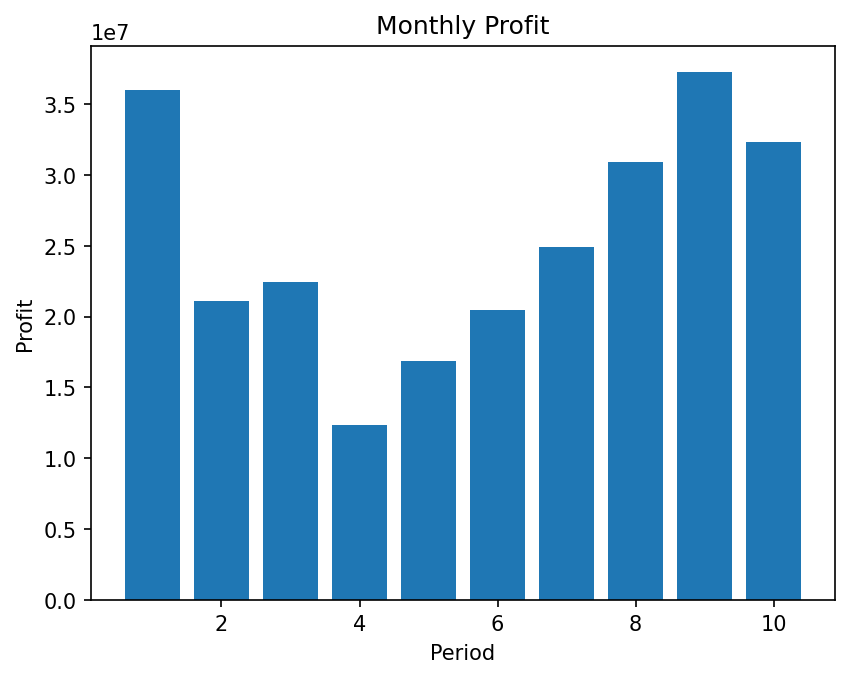

In [590]:
import matplotlib.pyplot as plt

plt.figure(dpi=150)
plt.bar(x=np.linspace(1, n_periods, n_periods), height=monthly_profit)
plt.title("Monthly Profit")
plt.xlabel("Period")
plt.ylabel("Profit")
plt.show()


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])